In [1]:
# %%
import arviz as az
import matplotlib.pyplot as plt
import pyro
import pyro.contrib.gp
import pyro.distributions as dist
import pyro.infer
import seaborn as sns
import sklearn.model_selection
import torch

sns.set_style("whitegrid")
# torch.random.manual_seed(1337)


In [2]:
# %%


# we assume that observations are given by
# y_i = g(x_i) + epsilon
# epsilon ~ N(0, 0.01)
# where the observations are the grid x_i = (i-1)/(ell-1) for i=1,...,ell with ell=30.
def sample_data_from(g, size=30):
    x = torch.linspace(0, 1, size)
    epsilon = torch.randn(size) * 0.01
    y = g(x) + epsilon
    return x, y


In [3]:
def g(x):
    return -(torch.sin(6 * torch.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


In [4]:
def get_data():
    X, y = sample_data_from(g)

    # print("X1",X)
    X, X_test, y, y_test = sklearn.model_selection.train_test_split(
        X, y, test_size=10, random_state=1337
    )
    # print("X",X)
    # print("X_test",X_test)
    # print("y",y)
    # print("y_test",y_test)
    # Print the shapes
    # print("X shape:", X.shape)
    # print("X_test shape:", X_test.shape)
    # print("y shape:", y.shape)
    # print("y_test shape:", y_test.shape)

    return X, X_test, y, y_test


In [5]:
pyro.clear_param_store()

# implement a standard GP model using the maximum a-posteriori estimate of hyper
# parameters and compare that to the sampled GP using NUTS


In [6]:
def get_kernel(l, v, p):
    return pyro.contrib.gp.kernels.Periodic(
        input_dim=1, lengthscale=l, variance=v, period=p
    )


In [7]:
# Select a suitable model with your own choice of kernel. Identify the parameters
# of the model and decide which parameters are fixed and which are variable
# (you need ≥ 2 variable parameters). We will refer to the variable parameters as theta.
# For each parameter, pick a suitable prior distribution and implement the model
# (or use the GP implemented in Pyro) as well as a function implementing log p(y, θ|X).
def model(X, y=None) -> pyro.contrib.gp.models.GPRegression:
    period = pyro.sample("period", dist.Uniform(0.01, 0.1667))
    lengthscale = pyro.sample("lengthscale", dist.Normal(0, 1))
    # print("Sampled period:", period.item())
    # print("Sampled lengthscale:", lengthscale.item())
    kernel = pyro.contrib.gp.kernels.Sum(
        pyro.contrib.gp.kernels.Periodic(input_dim=1, period=period),
        pyro.contrib.gp.kernels.RBF(input_dim=1, lengthscale=lengthscale),
    )
    # cov_matrix = kernel(X).detach().numpy()
    # print("Covariance matrix:\n", cov_matrix)
    # print()
    # noise=torch.tensor(0.01)
    return pyro.contrib.gp.models.GPRegression(X, y, kernel, jitter=1e-6)


In [8]:
def plot_gp(gp, name):
    Xnew = torch.linspace(0, 1, 100)
    means, covs = gp(Xnew, full_cov=True)
    means = means.detach().numpy()
    covs = covs.detach()
    sd = covs.diag().sqrt().numpy()
    # print(sd)
    # plot the posterior mean and variance of the GP
    sns.lineplot(x=Xnew, y=means, label="mean", color="black")
    plt.fill_between(
        Xnew,
        means - sd,
        means + sd,
        alpha=0.3,
        color="black",
        label="standard deviation",
    )
    sns.scatterplot(x=X, y=y, label="training data", color="red")
    sns.scatterplot(x=X_test, y=y_test, label="test data", color="orange")
    plt.plot(Xnew, g(Xnew), "k--", lw=2, label="True function g(x)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title(name)
    plt.savefig("Task3", dpi=300)
    plt.show()


In [9]:
import pyro

# def task2(X, y, X_test, y_test):

#     pyro.clear_param_store()
#     # Use SVI to fit the model to the training data
#     gp = model(X, y)
#     losses = pyro.contrib.gp.util.train(gp, num_steps=1000)

#     # Plot the loss
#     plt.figure(figsize=(10, 5))  # Optional: Define the size of the figure
#     sns.lineplot(x=range(len(losses)), y=losses)
#     plt.title('Training Loss Over Time')  # Add a title to the plot
#     plt.xlabel('Iteration')  # Label for the x-axis
#     plt.ylabel('Loss')  # Label for the y-axis
#     plt.savefig("Task2.png", dpi=300)  # Save the plot with high resolution
#     plt.show()  # Display the plot

#     # Access the learned parameters (theta*) from the GP model
#     theta_star = {name: pyro.param(name).detach().cpu().numpy()
#                   for name in pyro.get_param_store().keys()}
#     print("Learned Parameters (theta*):", theta_star)

#     # Evaluate the posterior log-likelihood of the test set on the fitted GP using θ*
#     posterior_log_likelihood = evaluate(gp, X_test, y_test).item()
#     print("Posterior log-likelihood of the test set:", posterior_log_likelihood)

#     return theta_star, posterior_log_likelihood


def task2(X, y, X_test, y_test):
    pyro.clear_param_store()

    # Define the guide for MAP estimation
    def guide(X, y):
        # Point estimates for hyperparameters
        pyro.param(
            "period_map",
            torch.tensor(0.1),
            constraint=dist.constraints.interval(0.01, 0.1667),
        )
        pyro.param(
            "lengthscale_map", torch.tensor(1.0), constraint=dist.constraints.positive
        )
        pyro.sample("period", dist.Delta(pyro.param("period_map")))
        pyro.sample("lengthscale", dist.Delta(pyro.param("lengthscale_map")))

    # Setup the SVI object
    svi = pyro.infer.SVI(
        model=model,
        guide=guide,
        optim=pyro.optim.Adam({"lr": 0.01}),
        loss=pyro.infer.Trace_ELBO(),
    )

    # Optimization loop
    losses = []
    for step in range(1000):
        loss = svi.step(X, y)
        losses.append(loss)

    # Plot the loss
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(len(losses)), y=losses)
    plt.title("Training Loss Over Time")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.savefig("Task2.png", dpi=300)
    plt.show()

    # Access the learned parameters (theta*) from the GP model
    theta_star = {
        "period_map": pyro.param("period_map"),
        "lengthscale_map": pyro.param("lengthscale_map"),
    }
    print("Learned Parameters (theta*):", {k: v.item() for k, v in theta_star.items()})

    # Evaluate the posterior log-likelihood of the test set on the fitted GP using θ*
    # Create the GP model using the MAP estimates
    print(theta_star["period_map"])
    print(["lengthscale_map"])
    kernel = pyro.contrib.gp.kernels.Sum(
        pyro.contrib.gp.kernels.Periodic(input_dim=1, period=theta_star["period_map"]),
        pyro.contrib.gp.kernels.RBF(
            input_dim=1, lengthscale=theta_star["lengthscale_map"]
        ),
    )
    gp = pyro.contrib.gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.01))
    posterior_log_likelihood = evaluate(gp, X_test, y_test).item()
    print("Posterior log-likelihood of the test set:", posterior_log_likelihood)

    return theta_star, posterior_log_likelihood


In [10]:
# X, X_test, y, y_test = get_data()
# task2(X, y, X_test, y_test)

In [11]:
# def compute_log_likelihood(posterior_samples, X_test, y_test):
#     likelihoods = []
#     for lengthscale, period in zip(posterior_samples["lengthscale"], posterior_samples["period"]):
#         with pyro.plate("data"):
#             kernel = pyro.contrib.gp.kernels.Sum(
#                 pyro.contrib.gp.kernels.Periodic(input_dim=1, period=period),
#                 pyro.contrib.gp.kernels.RBF(input_dim=1, lengthscale=lengthscale),
#             )
#             gp = pyro.contrib.gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.01))
#             likelihoods.append(evaluate(gp, X_test, y_test).item())
#     return torch.tensor(likelihoods)
# def compute_log_likelihood(posterior_samples, X_test, y_test):
#     likelihoods = []
#     for lengthscale, period in zip(posterior_samples["lengthscale"], posterior_samples["period"]):
#         kernel = pyro.contrib.gp.kernels.Sum(
#             pyro.contrib.gp.kernels.Periodic(input_dim=1, period=period),
#             pyro.contrib.gp.kernels.RBF(input_dim=1, lengthscale=lengthscale),
#         )
#         gp = pyro.contrib.gp.models.GPRegression(X, y, kernel)

#         means, covs = gp(X_test, full_cov=True)
#         # jitter = 1e-6  # You might need to adjust this value
#         # covs = covs + torch.eye(covs.size(0)) * jitter

#         log_likelihood = dist.MultivariateNormal(means, covs).log_prob(y_test)

#         # Diagnostic prints
#         # print("Lengthscale:", lengthscale)
#         # print("Period:", period)
#         # print("Means:", means)
#         # print("Covariance Matrix:", covs)
#         # print("Log Likelihood:", log_likelihood.item())

#         likelihoods.append(log_likelihood.item())
#     return torch.tensor(likelihoods)


In [12]:
def compute_log_likelihood(posterior_samples, X_test, y_test):
    likelihoods = []
    for kernel_params in zip(*posterior_samples.values()):
        with pyro.plate("data"):
            kernel = get_kernel(*kernel_params)
            gp = pyro.contrib.gp.models.GPRegression(
                X, y, kernel, noise=torch.tensor(0.01)
            )

            likelihoods.append(evaluate(gp, X_test, y_test).item())
    return torch.tensor(likelihoods)


In [13]:
def evaluate(gp: pyro.contrib.gp.models.GPRegression, X_test, y_test):
    # Add a print statement before calling gp
    # print("Before calling gp" , X_test.shape)

    means, covs = gp(X_test, full_cov=True)
    # print("HEJ")
    # print(covs)
    # print("HEJ22")
    # Add a print statement after calling gp
    # print("After calling gp")

    log_likelihood = dist.MultivariateNormal(means, covs).log_prob(y_test)
    return log_likelihood


In [14]:
def task3(X, y, X_test, y_test):
    pyro.clear_param_store()

    # Use NUTS to sample from the posterior. Check the quality of the MCMC
    # sampling using diagnostics (Arviz). Use the diagnostics to choose the
    # hyperparameters of the sampling (such as the number of warmup samples).

    nuts_kernel = pyro.infer.NUTS(model)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=200, num_chains=2, warmup_steps=400)
    mcmc.run(X, y)
    posterior_samples = az.from_pyro(mcmc)
    az.ess(posterior_samples)
    az.plot_posterior(posterior_samples)

    # Use ArviZ diagnostics to assess the quality of the sampling
    az.plot_trace(posterior_samples, var_names=["lengthscale", "period"])
    plt.show()
    az.summary(posterior_samples)

    summary_stats = az.summary(posterior_samples)
    print(summary_stats)
    posterior_samples = mcmc.get_samples()
    # print(posterior_samples)
    # Plot the posterior mean and variance of the GP
    lengthscale = posterior_samples["lengthscale"].mean()
    period = posterior_samples["period"].mean()
    # print(lengthscale)
    # print(period)
    kernel = pyro.contrib.gp.kernels.Sum(
        pyro.contrib.gp.kernels.Periodic(input_dim=1, period=period),
        pyro.contrib.gp.kernels.RBF(input_dim=1, lengthscale=lengthscale),
    )
    gp = pyro.contrib.gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.01))
    plot_gp(gp, "GP Regression")
    # print("HEJ")
    # print(posterior_samples)
    # Compute the posterior log-likelihood of the test set
    # print("Posterior samples",posterior_samples)
    # print(y_test)
    log_likelihoods = compute_log_likelihood(posterior_samples, X_test, y_test)
    print(log_likelihoods)
    # print(log_likelihoods.shape)
    # print(torch.mean(log_likelihoods))
    # print(torch.std(log_likelihoods))


In [15]:
def task4(X, y, X_test, y_test):
    pyro.clear_param_store()

    # Adjust the NUTS kernel with the model
    nuts_kernel = pyro.infer.NUTS(model)

    # Use MCMC to sample 500 values of θ (hyperparameters) from the posterior
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=400)
    mcmc.run(X, y)

    # Extract the samples from MCMC
    posterior_samples = mcmc.get_samples()
    print("X_test", X_test)
    print("X", X)
    print("y", y)
    print("y_test", y_test)
    print("posterior_samples", posterior_samples)
    # Compute the posterior log-likelihood for each sample
    log_likelihoods = compute_log_likelihood(posterior_samples, X_test, y_test)

    # Compute the mean and standard deviation of the log likelihoods
    mean_log_likelihood = torch.mean(log_likelihoods)
    std_log_likelihood = torch.std(log_likelihoods)

    print("Mean posterior log-likelihood of the test set:", mean_log_likelihood)
    print("Standard deviation of the posterior log-likelihood:", std_log_likelihood)

    return mean_log_likelihood, std_log_likelihood


In [16]:
def task5():
    # Initialize lists to store results
    map_likelihoods = []
    mcmc_likelihoods = []

    # Perform 20 iterations for different datasets
    for _ in range(1):
        # Generate a new dataset
        X, X_test, y, y_test = get_data()

        # Task 2: Fitting a GP Model using SVI (MAP approach)
        theta_star, posterior_log_likelihood_map = task2(X, y, X_test, y_test)
        map_likelihoods.append(posterior_log_likelihood_map)

        # Task 4: Approximate Posterior Likelihood with MCMC
        mean_log_likelihood_mcmc, _ = task4(X, y, X_test, y_test)
        mcmc_likelihoods.append(mean_log_likelihood_mcmc)

    # Calculate mean and standard deviation for MAP and MCMC likelihoods
    map_mean = torch.mean(torch.tensor(map_likelihoods))
    map_std = torch.std(torch.tensor(map_likelihoods))

    mcmc_mean = torch.mean(torch.tensor(mcmc_likelihoods))
    mcmc_std = torch.std(torch.tensor(mcmc_likelihoods))

    # Report the results
    print("MAP Likelihoods Mean:", map_mean)
    print("MAP Likelihoods Std Deviation:", map_std)
    print("MCMC Likelihoods Mean:", mcmc_mean)
    print("MCMC Likelihoods Std Deviation:", mcmc_std)
    # print("MCMC likelihoods", mcmc_likelihoods)


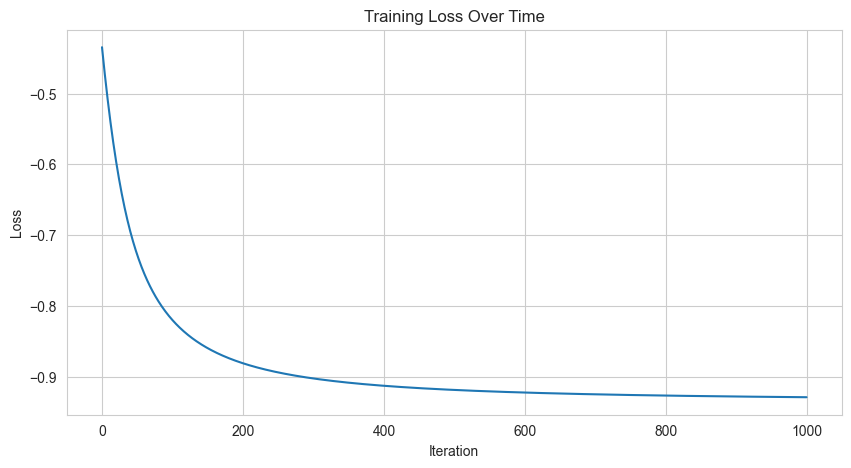

Learned Parameters (theta*): {'period_map': 0.10000000149011612, 'lengthscale_map': 0.10481841117143631}
tensor(0.1000, grad_fn=<AddBackward0>)
['lengthscale_map']
Posterior log-likelihood of the test set: -123.50938415527344


Warmup [1]:   0%|          | 0/900 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/900 [00:00, ?it/s]

Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
    exitcode = _main(fd, parent_sentinel)
                       ^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
^^^
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
    self = reduction.pickle.load(from_parent) 
          ^^^^^^^^^^^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^AttributeError^^: ^Can't get attribute 'model' on <module '__main__' (<class '_

KeyboardInterrupt: 

In [17]:
task5()

In [ ]:
if __name__ == "__main__":
    X, X_test, y, y_test = get_data()
    task3(X, y, X_test, y_test)
    task2(X, y, X_test, y_test)
    # task4(X, y, X_test, y_test)
    # task5()


# %%

# plt.bar("Gradient descent", np.sum(likelihoods_gd))
plt.bar("MCMC", np.sum(likelihoods_mcmc))
plt.show()

# %%
